__Imports__

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.special as sp
import math
import matplotlib.gridspec as gridspec
import scipy

Lightning Approximation:

$$ f(z) \approx r(z) = \sum^{N_1}_{j=1}\frac{a_j p_j}{z-p_j} + \sum_{j=0}^{N_2}b_j T_j(z)$$

__Defining $N$, $N_1$, and $N_2$__

In [2]:
N1_old = np.linspace(1,132,80)
N1 = N1_old.astype(int)
#N2_old = np.ceil(1.1*np.sqrt(N1)-1)
N2_old = np.ceil(1.3*np.sqrt(N1))
N2 = N2_old.astype(int)
N = N1+N2

The function returning the poles, $p_j$, and the coefficients $a_j$ and $b_j$

In [3]:
def coeffs(N1,N2,resolution):
    sigma = 2*np.sqrt(2)*np.pi
    p = np.zeros(N1)
    
    for j in range(1,N1+1):
        p[j-1] = -np.exp(-sigma*(np.sqrt(N1)-np.sqrt(j)))
        
    t_old = np.logspace(resolution,0,2000)
    t = np.insert(t_old,0,0)
    #t = t_old
    f = np.sqrt(t)
    
    A = np.zeros((len(t),N1+N2+1))
    
    for i in range(N1):
        A[:,i] = p[i]/(t-p[i])
    
    for k in range(N2+1):
        A[:,N1+k] = sp.eval_chebyt(k,2*t-1)
    
    tol = 2e-14
    Uv, sv, VvT = np.linalg.svd(A, full_matrices=False)
    ID = sv >= tol
    c = Uv[:, ID].T @ f 
    c = VvT[ID, :].T @ (c / sv[ID])

    a = c[0:N1]
    b = c[N1:]

    return a,b,p

__The rational approximation function implementing the poles and coefficients from above for real numbers__

In [4]:
def rat_approx(a,b,p,z):
    r = 0
    for i in range(len(a)):
        r += a[i]*p[i]/(z-p[i])
    for j in range(len(b)):
        r += b[j]*sp.eval_chebyt(j,2*z-1)
    
    return r

__A function returning the max absolute error across the different $N_1$ values__

In [5]:
def error(N1,N2,z,resolution):
    y = np.zeros(len(N1))
    for i in range(len(N1)):
        a,b,p = coeffs(N1[i],N2[i],resolution)
        r = rat_approx(a,b,p,z)
        y[i] = np.linalg.norm(r - np.sqrt(z),
                              ord=np.inf)
    return y,p

__Comparing the errors across different training resolutions__

In [6]:
z = np.logspace(-64,0,1000) 

er2, p2 = error(N1,N2,z,-2)
er4, p4 = error(N1,N2,z,-4)
er6, p6 = error(N1,N2,z,-6)
er8, p8 = error(N1,N2,z,-8)
er16, p16 = error(N1,N2,z,-16)
er24, p24 = error(N1,N2,z,-24)
er32, p32 = error(N1,N2,z,-32)
er40, p40 = error(N1,N2,z,-40)
er48, p48 = error(N1,N2,z,-48)
er56, p56 = error(N1,N2,z,-56)
er64, p64 = error(N1,N2,z,-64)

[Text(0.5, 0, 'sqrt(N)'),
 Text(0, 0.5, 'max error'),
 Text(0.5, 1.0, 'Resolution Comparison')]

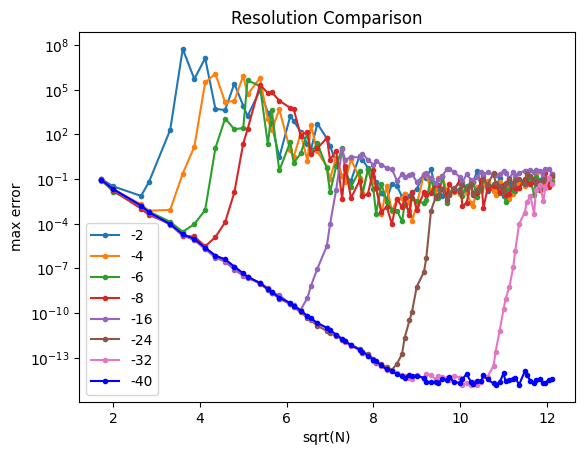

In [7]:
fig, ax = plt.subplots(1)

ax.plot(np.sqrt(N), er2, ".-", label='-2')
ax.plot(np.sqrt(N), er4, ".-", label='-4')
ax.plot(np.sqrt(N), er6, ".-", label='-6')
ax.plot(np.sqrt(N), er8, ".-", label='-8')
ax.plot(np.sqrt(N), er16, ".-", label='-16')
ax.plot(np.sqrt(N), er24, ".-", label='-24')
ax.plot(np.sqrt(N), er32, ".-", label='-32')
ax.plot(np.sqrt(N), er40, ".-", label='-40',color='b')
#ax.plot(np.sqrt(N), er48, ".-", label='-48',color='g')
#ax.plot(np.sqrt(N), er56, ".-", label='-56',color='k')
#ax.plot(np.sqrt(N), er64, ".-", label='-64',color='y')

ax.set_yscale('log')
ax.legend()
ax.set(xlabel="sqrt(N)",ylabel="max error",title='Resolution Comparison')


__Comparing the relationship between minimum pole order of magnitude and maximum error across different tuning resolutions__

In [8]:
def oom(number):
  """
  Returns the order of magnitude of a number.
  """
  if number == 0:
    return 0
  return math.floor(math.log10(abs(number)))

In [9]:
def pole_er(t_res,er,res,ax):
    t = np.logspace(t_res,0,2000)
    #i = np.argmax(er)
    i = np.argwhere(np.diff(er)>0)[0]
    
    a,b,p = coeffs(N1[i[0]+1],N2[i[0]+1],res)
    r = rat_approx(a,b,p,t)
    er = abs(r-np.sqrt(t))

    mag = oom(p[0])
    #print(p[0])

    #fig,ax = plt.subplots(1)
    ax.plot(t,er,label=res)
    ax.axvline(x=abs(p[0]), linestyle='dashed', color='g')

    #ax.set(ylabel='approx error')
    ax.set_xscale('log')
    ax.set_yscale('log')

    #ax.legend()

                     minimum pole and max error intersection


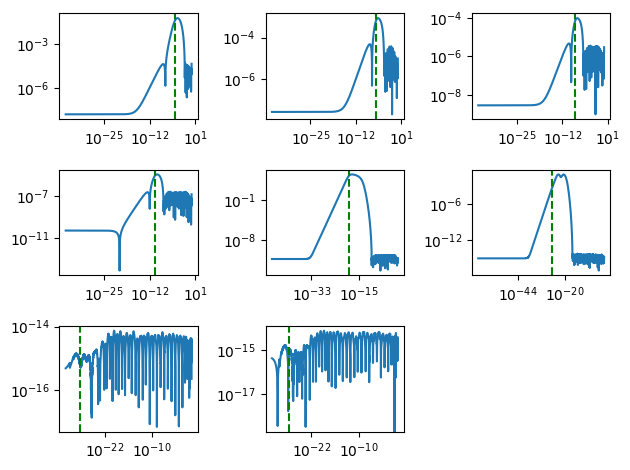

In [10]:
print('                     minimum pole and max error intersection')
gs = gridspec.GridSpec(3, 3)

ax2 = plt.subplot(gs[0,0])
pole_er(-36,er2,-2,ax2)

ax4 = plt.subplot(gs[0,1])
pole_er(-36,er4,-4,ax4)

ax6 = plt.subplot(gs[0,2])
pole_er(-36,er6,-6,ax6)

ax8 = plt.subplot(gs[1,0])
pole_er(-36,er8,-8,ax8)

ax16 = plt.subplot(gs[1,1])
pole_er(-48,er16,-10,ax16)

ax24 = plt.subplot(gs[1,2])
pole_er(-64,er24,-16,ax24)

ax32 = plt.subplot(gs[2,0])
pole_er(-32,er32,-32,ax32)

ax40 = plt.subplot(gs[2,1])
pole_er(-32,er40,-40,ax40)

plt.tight_layout()
plt.show()


__Adapting the rational approximation function to estimate $A^{1/2}\mathbf{u}$, implements the Clenshaw Algorithm for the Chebyshev polynomial sum__

$$A^{1/2}\mathbf{u} \approx r(A)\mathbf{u} = \sum^{N_1}_{j=1}a_j p_j (A-p_j I)^{-1}\mathbf{u} + \sum^{N_2}_{j=0}b_j T_j(A)\mathbf{u}$$

In [11]:
def matrix_rat(a,b,p,A,u):
    
    #first part of sum
    sum1 = 0
    I = np.eye(A.shape[0])
    for i in range(len(a)):
        sum1 += a[i]*p[i]*np.linalg.solve(A-p[i]*I,u)
    
    #Chebyshev part w/ Clenshaw 
    W = 2*A - I
    
    bb = np.zeros((len(b)+2,W.shape[0],1))
    for k in range(len(b)-1,0,-1):
        bb[k] = b[k]*u + 2*W@bb[k+1] -bb[k+2]
    sum2 = b[0]*u +W@bb[1] -bb[2]

    return sum1+sum2

__First Tests__

In [12]:
A = np.diag((0.25,(4/9),(9/25)))
u = np.array([2,1.5,(5/3)]).reshape(3,1)

a,b,p = coeffs(N1[79],N2[79],-16)
approx = matrix_rat(a,b,p,A,u)

error = approx - np.array([1,1,1]).reshape(3,1)
error

array([[ 2.22044605e-15],
       [-2.22044605e-15],
       [ 1.11022302e-15]])

In [13]:
m = 1000
A = np.zeros((m,m))
A_root = np.zeros((m,m))
for i in range(m):
    A[i,i] = (i+1)**2/(i+2)**2
    A_root[i,i] = (i+1)/(i+2)

u = np.random.rand(m,1)

a,b,p = coeffs(N1[20],N2[20],-16)
approx = matrix_rat(a,b,p,A,u)
exact = A_root @ u

error = np.linalg.norm(approx-exact,np.inf)
error

6.923572826167401e-12

In [14]:
#householder
m = 5
A = np.zeros((m,m))
A_root = np.zeros((m,m))
for i in range(m):
    A[i,i] = 1/(i+1)**2
    A_root[i,i] = 1/(i+1)

v = np.random.randn(m,1)
v = v/np.linalg.norm(v,2)

V = np.eye(m)-2*v@v.T

A = V@A@V.T #same eigenvalues of original A
A_root = V@A_root@V.T

u = np.random.randn(m,1)

a,b,p = coeffs(N1[20],N2[20],-16)
approx = matrix_rat(a,b,p,A,u)
exact = A_root @ u

error = (np.linalg.norm(approx-exact,np.inf)
         /np.linalg.norm(exact,np.inf))
error

3.6517406522073534e-11

__Random Adjacency Matrix__

In [15]:
import random

def random_adjacency_matrix(n):   
    matrix = [[random.randint(0, 1) for i in range(n)] 
              for j in range(n)]

    # No vertex connects to itself
    for i in range(n):
        matrix[i][i] = 0

    # If i is connected to j, j is connected to i
    for i in range(n):
        for j in range(n):
            matrix[j][i] = matrix[i][j]

    return np.array(matrix)

__Example of a graph__

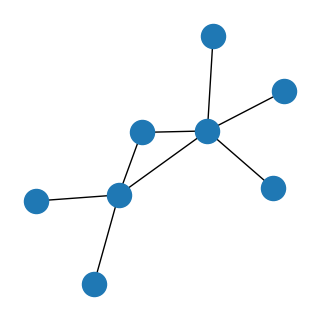

In [16]:
import networkx as nx

plt.figure(figsize=(3,3))
G = nx.Graph()
G.add_nodes_from(range(1,8))
G.add_edges_from([(1,3),(2,3),(3,4),(3,5),(3,6),(5,6),
                  (6,8),(6,7)])
nx.draw(G)
plt.show()

__K Nearest Neighbors Graph Adjacency Matrix__

In [17]:
#sklearn.neighbors
from sklearn.neighbors import kneighbors_graph
from scipy.stats import qmc
from scipy.sparse import identity

def randmat(n,k):
    
    sampler = qmc.Halton(d=2, scramble=False)
    X = sampler.random(n)

    A = kneighbors_graph(X,k,mode='connectivity', 
                         include_self=False)
    #A.toarray()

    #A = A - identity(n,format='csr')

    A = scipy.sparse.tril(A) + scipy.sparse.tril(A).T

    return (A)

__Adapting the matrix rational approximation for sparse matrices__

In [18]:
def matrix_rat_sparse(a,b,p,A,u):
    
    #first part of sum
    sum1 = 0
    I = identity(A.shape[0],format='csr')
    for i in range(len(a)):
        sum1 += (a[i]*p[i]*
                 scipy.sparse.linalg.spsolve(A-p[i]*I,u))

    sum1 = sum1.reshape(-1,1)

    #Chebyshev part w/ Clenshaw 
    W = 2*A - I
    
    bb = np.zeros((len(b)+2,W.shape[0],1))
    for k in range(len(b)-1,0,-1):
        bb[k] = b[k]*u + 2*W@bb[k+1] -bb[k+2]
    sum2 = b[0]*u +W@bb[1] -bb[2]

    return sum1+sum2

__Initial tests__

In [19]:
n = 100
k=5
u = np.random.randn(n,1)

A = randmat(n,k)
D = A@np.ones(n)
D = scipy.sparse.diags((1/np.sqrt(D)))

L_norm = identity(n,format='csr') - D@A@D
T = identity(n, format='csr') - 0.5*L_norm

a,b,p = coeffs(N1[20],N2[20],-16)
approx = matrix_rat_sparse(a,b,p,T,u)
exact = scipy.linalg.sqrtm(T.toarray()) @ u

error = (np.linalg.norm(approx-exact,np.inf)
         /np.linalg.norm(exact,np.inf))
error

7.585339320051707e-12

__Comparing the relative error by matrix size and $N_1$ values for the dense solver__

In [20]:
def mat_err(n, N1, N2):
    A = random_adjacency_matrix(n)
    
    D = np.zeros(A.shape)
    D_root = np.zeros(A.shape)
    for i in range(n):
        D[i,i] = sum(A[:,i])
        D_root[i,i] = 1/np.sqrt(D[i,i])

    u = np.random.randn(n,1)

    L_norm = np.eye(n) - D_root@A@D_root
    T = np.eye(n) - 0.5*L_norm

    a,b,p = coeffs(N1,N2,-16)
    approx = matrix_rat(a,b,p,T,u)
    exact = scipy.linalg.sqrtm(T) @ u

    error = (np.linalg.norm(approx-exact,np.inf)
             /np.linalg.norm(exact,np.inf))

    return (error)

def full_errs(j,m):
    n = np.linspace(10,2000,m).astype(int)

    n1 = N1[j]
    n2 = N2[j]

    errors = np.zeros(m)
    for i in range(m):
        errors[i] = mat_err(n[i],n1,n2)

    return (errors)

In [21]:
m = 11

errors9 = full_errs(9,m)

In [ ]:
errors19 = full_errs(19,m)

In [ ]:
errors29 = full_errs(29,m)

In [ ]:
errors39 = full_errs(39,m)

In [ ]:
errors49 = full_errs(49,m)

In [ ]:
errors59 = full_errs(59,m)

In [ ]:
errors69 = full_errs(69,m)

In [ ]:
errors79 = full_errs(79,m)

[Text(0.5, 0, 'n'),
 Text(0, 0.5, 'Error'),
 Text(0.5, 1.0, 'Dense Relative Error by Matrix Size (nxn)')]

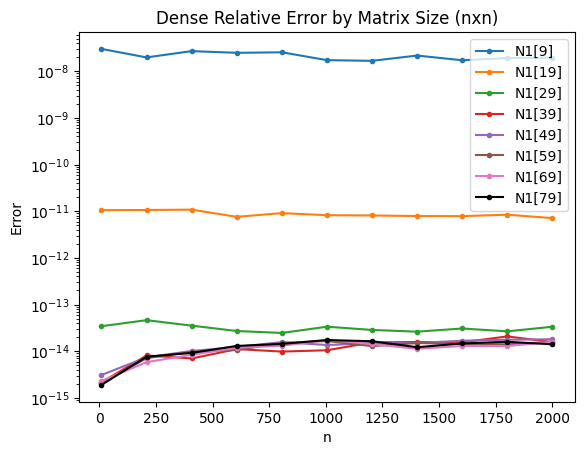

In [ ]:
n = np.linspace(10,2000,m).astype(int)

fig,ax = plt.subplots(1)
ax.plot(n,errors9,".-",label='N1[9]')
ax.plot(n,errors19,".-",label='N1[19]')
ax.plot(n,errors29,".-",label='N1[29]')
ax.plot(n,errors39,".-",label='N1[39]')
ax.plot(n,errors49,".-",label='N1[49]')
ax.plot(n,errors59,".-",label='N1[59]')
ax.plot(n,errors69,".-",label='N1[69]')
ax.plot(n,errors79,".-",label='N1[79]',color='k')

ax.set_yscale('log')
ax.legend()
ax.set(xlabel='n',ylabel='Error',
       title='Dense Relative Error by Matrix Size (nxn)')

__Comparing the relative error by matrix size and $N_1$ values for the sparse solver__

In [ ]:
def mat_err_sparse(n, N1, N2):
    #Forming the matrix T and vector u
    k=5
    u = np.random.randn(n,1)

    A = randmat(n,k)
    D = A@np.ones(n)
    D = scipy.sparse.diags((1/np.sqrt(D)))

    L_norm = identity(n,format='csr') - D@A@D
    T = identity(n, format='csr') - 0.5*L_norm

    #Computing the approximation and error
    a,b,p = coeffs(N1,N2,-16)
    approx = matrix_rat_sparse(a,b,p,T,u)
    exact = scipy.linalg.sqrtm(T.toarray()) @ u
    
    error = (np.linalg.norm(approx-exact,np.inf)
             /np.linalg.norm(exact,np.inf))

    return (error)

def full_errs_sparse(j,m):
    n = np.linspace(10,2000,m).astype(int)

    n1 = N1[j]
    n2 = N2[j]

    errors = np.zeros(m)
    for i in range(m):
        errors[i] = mat_err_sparse(n[i],n1,n2)

    return (errors)

In [ ]:
m = 11

sp_errors9 = full_errs_sparse(9,m)

In [ ]:
sp_errors19 = full_errs_sparse(19,m)

In [ ]:
sp_errors29 = full_errs_sparse(29,m)

In [ ]:
sp_errors39 = full_errs_sparse(39,m)

In [ ]:
sp_errors49 = full_errs_sparse(49,m)

In [ ]:
sp_errors59 = full_errs_sparse(59,m)

In [ ]:
sp_errors69 = full_errs_sparse(69,m)

In [ ]:
sp_errors79 = full_errs_sparse(79,m)

[Text(0.5, 0, 'n'),
 Text(0, 0.5, 'Error'),
 Text(0.5, 1.0, 'Sparse Relative Error by Matrix Size (nxn)')]

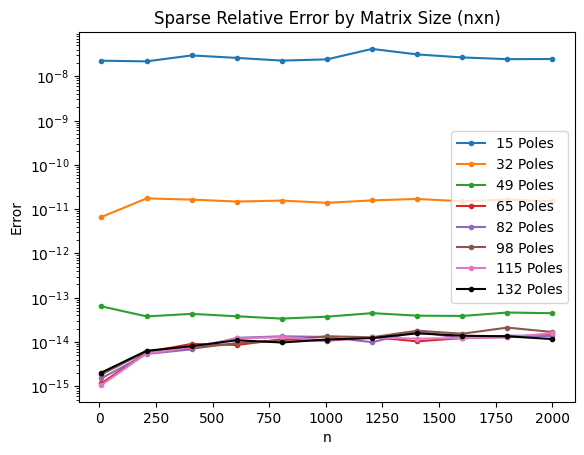

In [ ]:
n = np.linspace(10,2000,m).astype(int)

fig,ax = plt.subplots(1)
ax.plot(n,sp_errors9,".-",label='15 Poles')
ax.plot(n,sp_errors19,".-",label='32 Poles')
ax.plot(n,sp_errors29,".-",label='49 Poles')
ax.plot(n,sp_errors39,".-",label='65 Poles')
ax.plot(n,sp_errors49,".-",label='82 Poles')
ax.plot(n,sp_errors59,".-",label='98 Poles')
ax.plot(n,sp_errors69,".-",label='115 Poles')
ax.plot(n,sp_errors79,".-",label='132 Poles',color='k')

ax.set_yscale('log')
ax.legend()
ax.set(xlabel='n',ylabel='Error',
       title='Sparse Relative Error by Matrix Size (nxn)')

__Comparing the computation times between the sparse solver and exact root__

In [ ]:
import time

def timing_approx(N1,N2,n):
    times = np.zeros(len(n))
    
    for i in range(len(n)):
        #make T and u
        k=5
        u = np.random.randn(n[i],1)
        A = randmat(n[i],k)
        D = A@np.ones(n[i])
        D = scipy.sparse.diags((1/np.sqrt(D)))

        L_norm = identity(n[i],format='csr') - D@A@D
        T = identity(n[i], format='csr') - 0.5*L_norm
        
        #time it
        start = time.perf_counter()
        a,b,p = coeffs(N1,N2,-16)
        approx = matrix_rat_sparse(a,b,p,T,u)
        end = time.perf_counter()
        times[i] = end-start

    return times

def timing_exact(n):
    times = np.zeros(len(n))

    for i in range(len(n)):
        #make T and u
        k=5
        u = np.random.randn(n[i],1)
        A = randmat(n[i],k)
        D = A@np.ones(n[i])
        D = scipy.sparse.diags((1/np.sqrt(D)))

        L_norm = identity(n[i],format='csr') - D@A@D
        T = identity(n[i], format='csr') - 0.5*L_norm
        
        #time it
        start = time.perf_counter()
        result = scipy.linalg.sqrtm(T.toarray()) @ u
        end = time.perf_counter()
        times[i] = end-start
        
    return times

In [ ]:
pip install tabulate 

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from tabulate import tabulate

n = np.array([10,100,1000,2000])

exact_times = timing_exact(n)
approx_times = timing_approx(N1[19],N2[19],n)

ns = np.array(['10','100','1000','2000'])
np.set_printoptions(suppress=True)
table = np.column_stack((ns,exact_times,approx_times))
headers = ['n','Exact Computation Time (sec)',
           'Lightning (32 Poles)']

print(tabulate(table,headers = headers, 
               tablefmt='fancy_grid',floatfmt='.6f'))

╒══════╤════════════════════════════════╤════════════════════════╕
│    n │   Exact Computation Time (sec) │   Lightning (32 Poles) │
╞══════╪════════════════════════════════╪════════════════════════╡
│   10 │                       0.003169 │               0.143525 │
├──────┼────────────────────────────────┼────────────────────────┤
│  100 │                       0.010215 │               0.079882 │
├──────┼────────────────────────────────┼────────────────────────┤
│ 1000 │                       1.386967 │               0.230912 │
├──────┼────────────────────────────────┼────────────────────────┤
│ 2000 │                      17.020127 │               0.586629 │
╘══════╧════════════════════════════════╧════════════════════════╛


__New Method: Minimax__

In [ ]:
def minimax(a,p,x):
    total = -a[0] 
    for i in range(len(p)):
        total += a[i+1]/(x-p[i]) 

    return (total)

__Loading coefficients and poles from chebfun for n=10 and n=14__

_Similar complexities for lightning are $N_1[6]$ and $N_1[8]$ (10 and 14 poles)_


In [ ]:
from scipy.io import loadmat
file_name = 'MinMaxRatN10.mat'
m_dict = loadmat(file_name)
a10 = m_dict['a']
p10 = m_dict['p']

file_name = 'MinMaxRatN14.mat'
m_dict = loadmat(file_name)
a14 = m_dict['a']
p14 = m_dict['p']

__Evaluating the different methods and comparing errors__

In [ ]:
j = 100
z = np.logspace(-16,0,j)

min10_est = np.zeros(j)
min14_est = np.zeros(j)
for i in range(j):
    min10_est[i] = minimax(a10,p10,z[i])
    min14_est[i] = minimax(a14,p14,z[i])

a10_o, b10_o, p10_o = coeffs(N1[6],N2[6],-32)
a14_o, b14_o, p14_o = coeffs(N1[8],N2[8],-32)

app10_est = rat_approx(a10_o,b10_o,p10_o,z)
app14_est = rat_approx(a14_o,b14_o,p14_o,z)

/var/folders/9l/7llcw8rd1jjgq13k9ckd1sf80000gr/T/ipykernel_12248/2842374665.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  min10_est[i] = minimax(a10,p10,z[i])
/var/folders/9l/7llcw8rd1jjgq13k9ckd1sf80000gr/T/ipykernel_12248/2842374665.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  min14_est[i] = minimax(a14,p14,z[i])


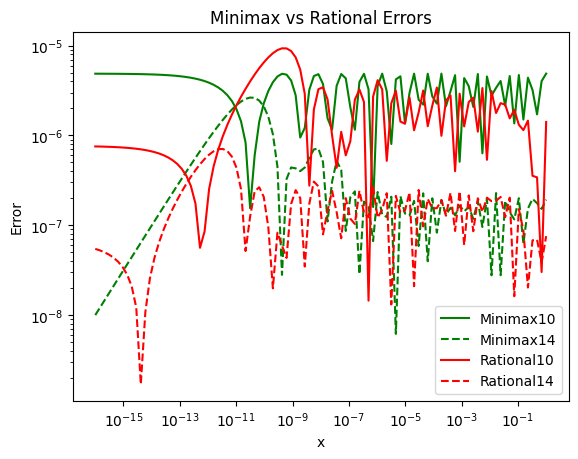

In [ ]:
exact = np.sqrt(z)

min10_er = abs(min10_est-exact)
min14_er = abs(min14_est-exact)

app10_er = abs(app10_est-exact)
app14_er = abs(app14_est-exact)

fig, ax = plt.subplots(1)
ax.plot(z,min10_er,color = 'g',label = 'Minimax10')
ax.plot(z,min14_er,linestyle='dashed',color = 'g',
        label='Minimax14')
ax.plot(z,app10_er,color = 'r',label='Rational10')
ax.plot(z,app14_er,linestyle = 'dashed', color = 'r',
        label='Rational14')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel='Error')
ax.set(xlabel='x')

ax.set(title = 'Minimax vs Rational Errors')
ax.legend()

__Adjusting the minimax function for dense and sparse matrices__

In [ ]:
def minimax_mat(a,p,A,u):
    total = -a[0]*u
    I = np.eye(A.shape[0])
    for i in range(len(p)):
        total += a[i+1]*np.linalg.solve(A-p[i]*I,u)
    return(total)


def minimax_mat_sp(a,p,A,u):
    total = -a[0]*u
    I = identity(A.shape[0], format='csr')
    for i in range(len(p)):
        test = scipy.sparse.linalg.spsolve(A-p[i][0]*I,u)
        fix = test.reshape(A.shape[0],1)
        total += a[i+1]*fix
    return(total)

__Initial Tests and Relative Error Comparisons__

In [ ]:
#Forming a matrix to test
n = 200
k=20

u = np.random.randn(n,1)

A = randmat(n,k)
D = A@np.ones(n)
D = scipy.sparse.diags((1/np.sqrt(D)))
L_norm = identity(n,format='csr') - D@A@D
T = 0.5*L_norm

exact = scipy.linalg.sqrtm(T.toarray()) @ u

In [ ]:
min10_mat_est = minimax_mat(a10,p10, T.toarray(),u)     
error10 = (np.linalg.norm(min10_mat_est-exact,np.inf)
           /np.linalg.norm(exact,np.inf))

min14_mat_est = minimax_mat(a14,p14,T.toarray(),u)
error14 = (np.linalg.norm(min14_mat_est-exact,np.inf)
           /np.linalg.norm(exact,np.inf))

sp_min10_mat_est = minimax_mat_sp(a10,p10,T,u)
sp_error10 = (np.linalg.norm(sp_min10_mat_est-exact,np.inf)
              /np.linalg.norm(exact,np.inf))

sp_min14_mat_est = minimax_mat_sp(a14,p14,T,u)
sp_error14 = (np.linalg.norm(sp_min14_mat_est-exact,np.inf)
              /np.linalg.norm(exact,np.inf))

a10r,b10r,p10r = coeffs(N1[6],N2[6],-16)
ratapp10 = matrix_rat_sparse(a10r,b10r,p10r,T,u)
raterror10 = (np.linalg.norm(ratapp10-exact,np.inf)
              /np.linalg.norm(exact,np.inf))

a14r,b14r,p14r = coeffs(N1[8],N2[8],-16)
ratapp14 = matrix_rat_sparse(a14r,b14r,p14r,T,u)
raterror14 = (np.linalg.norm(ratapp14-exact,np.inf)
              /np.linalg.norm(exact,np.inf))

min_dense = np.array([error10,error14]).reshape(2,1)
min_sparse = np.array([sp_error10,sp_error14]).reshape(2,1)
rat_sparse = np.array([raterror10,raterror14]).reshape(2,1)
complexity = np.array(['10','14']).reshape(2,1)

table = np.column_stack((complexity,min_dense,min_sparse,
                         rat_sparse))
headers = ['Complexity','Dense Minimax','Sparse Minimax',
           'Sparse Lightning']

print(tabulate(table,headers = headers, tablefmt='fancy_grid',
               floatfmt='.14f'))

╒══════════════╤══════════════════╤══════════════════╤════════════════════╕
│   Complexity │    Dense Minimax │   Sparse Minimax │   Sparse Lightning │
╞══════════════╪══════════════════╪══════════════════╪════════════════════╡
│           10 │ 0.00000475080555 │ 0.00000475080556 │   0.00000168862466 │
├──────────────┼──────────────────┼──────────────────┼────────────────────┤
│           14 │ 0.00000028998245 │ 0.00000028998241 │   0.00000007811952 │
╘══════════════╧══════════════════╧══════════════════╧════════════════════╛


__Comparing Lightning Approximation to Chebyshev polynomials for $\sqrt{x}$ on [0,1]__

In [ ]:
def chebycoeffs(f, n):
    """
    Computes the Chebyshev expansion coefficients for a 
    function defined on [0,1].

    Parameters:
    f : callable
        Function defined on [0,1].
    n : int
        Number of Chebyshev coefficients.

    Returns:
    coeffs : ndarray
        Chebyshev coefficients.
    """
    m = n - 1
    x = np.sin(np.pi * np.arange(-m, m+1, 2) / (2 * m))

    # Map [-1,1] to [0,1]
    fd = f(0.5 * (x + 1))
    #fd = f(2*x-1)
    
    reordered = np.concatenate([fd[n-1:0:-1], fd[:n-1]])
    coeffs = np.fft.ifft(reordered)

    result = np.zeros(n, dtype=complex)
    result[0] = coeffs[0]
    result[1:n-1] = 2 * coeffs[1:n-1]
    result[n-1] = coeffs[n-1]

    return result.real  # Return real part if f is real-valued

#compare with sqrt(x)
def f(x):
    return np.sqrt(x)

#implement the chebyshev coefficients
def cheb_approx(x,c):
    return np.polynomial.chebyshev.chebval(2*x-1,c)

In [ ]:
#implementing with n=11 for degree 10

# Coefficients for degree n  of Chebyshev coefficients
n = 11

# Compute the Chebyshev coefficients using the previously 
#defined function
cheb_coeffs = chebycoeffs(f, n)

#cheb approximation of sqrt(x) on [0,1]
x = np.linspace(0,1,1000)

cheb = cheb_approx(x,cheb_coeffs)
abs_er_cheb = abs(cheb-f(x))

a,b,p = coeffs(N1[6],N2[6],-64)
rat = rat_approx(a,b,p,x)
abs_er_rat = abs(rat-f(x))

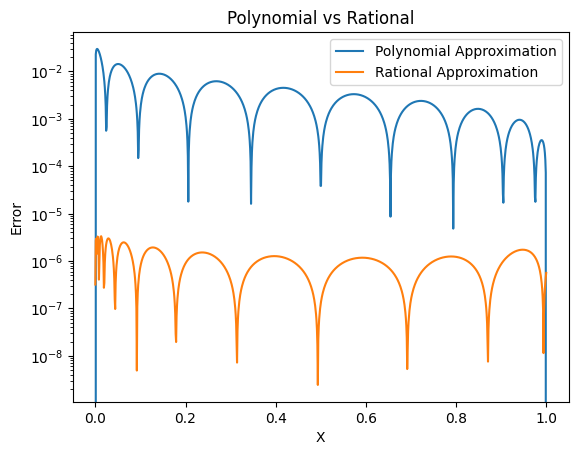

In [ ]:
fig,ax = plt.subplots(1)

ax.plot(x,abs_er_cheb,label='Polynomial Approximation')
ax.plot(x,abs_er_rat,label='Rational Approximation')

ax.set(xlabel='X',ylabel='Error',
       title='Polynomial vs Rational')
ax.legend()
ax.set_yscale('log')

Recurrence Relation: (indexing at 1)

$$f_j(t) = \sqrt{t^{2^{j-1}} - t^{2^j}}$$
$$f_1(t) = t^{1/2}\sqrt{1-t}$$
$$f_2(t) = t\sqrt{1-t}\sqrt{1+t}$$
$$f_n(t) = t^{2^{n-3}}\sqrt{1+t^{2^{n-2}}}*f_{n-1}(t) \text{ for } n=3,4,...$$


__Recurrence Relation Function for Scalars__

In [ ]:
def rec_rel(t,n,N1,N2,res):
    fs = np.zeros((len(t),n,1))
    
    a,b,p = coeffs(N1,N2,res)
    f0a = rat_approx(a,b,p,t) #f0a = t**0.5
    f0b = rat_approx(a,b,p,1-t) #f0b = np.sqrt(1-t)
    #fs0 = (f0a*f0b)
    fs[:,0] = f0a*f0b


    f1c = rat_approx(a,b,p,1+t)
    fs[:,1] = t*f0b*f1c #fs[1] = t*f0b*np.sqrt(1+t)

    for i in range(2,n):
        fia = t**(2**(i-2))
        fib = rat_approx(a,b,p,1+t**(2**(i-1))) 
        #fib = np.sqrt(1+t**(2**(n-1)))
        fs[:,i] = fia*fib*fs[:,i-1]

    return fs[:,n-1]

def true_rec_rel(t,n):
    fs = np.zeros((len(t),n,1))

    f0a = t**0.5
    f0b = np.sqrt(1-t)
    fs[:,0] = f0a*f0b

    fs[:,1] = t*f0b*np.sqrt(1+t)

    for i in range(2,n):
        fia = t**(2**(i-2))
        fib = np.sqrt(1+t**(2**(i-1)))
        fs[:,i] = fia*fib*fs[:,i-1]

    return fs[:,n-1]

def true2_rec(t,n):
    return np.sqrt(t**(2**(n-1))-t**(2**n))

__Replacing the $f_1$ and further terms with Chebyshev approximations__

In [ ]:
def chebycoeffs2(f, k, n):
    """
    Computes the Chebyshev expansion coefficients for a 
    function defined on [0,1].

    Parameters:
    f : callable
        Function defined on [0,1].
    n : int
        Number of Chebyshev coefficients.

    Returns:
    coeffs : ndarray
        Chebyshev coefficients.
    """
    m = k - 1
    x = np.sin(np.pi * np.arange(-m, m+1, 2) / (2 * m))

    # Map [-1,1] to [0,1]
    fd = f(0.5 * (x + 1),n)
    #fd = f(2*x-1)
    
    reordered = np.concatenate([fd[k-1:0:-1], fd[:k-1]])
    coeffs = np.fft.ifft(reordered)

    result = np.zeros(k, dtype=complex)
    result[0] = coeffs[0]
    result[1:k-1] = 2 * coeffs[1:k-1]
    result[k-1] = coeffs[k-1]

    return result.real  # Return real part if f is real-valued

#for f2 and further
def f(x,n):
    return (x**(2**(n-2)))*np.sqrt(1+x**(2**(n-1)))

#for f1c
def f2(x,n):
    return x*np.sqrt(1+x)

In [ ]:
#new version with Cheb coeffs
def rec_rel_cheb(t,n,N1,N2,res,f):
    
    fs = np.zeros((len(t),n,1))
    
    a,b,p = coeffs(N1,N2,res)
    f0a = rat_approx(a,b,p,t) #f0a = t**0.5
    f0b = rat_approx(a,b,p,1-t) #f0b = np.sqrt(1-t)
    #fs0 = (f0a*f0b)
    fs[:,0] = f0a*f0b

    f1coef = chebycoeffs2(f2,1*(max(N1,20)),0)
    f1c = cheb_approx(t,f1coef)
    
    fs[:,1] = f0b*f1c #fs[1] = t*f0b*np.sqrt(1+t)

    for i in range(2,n):
        cheb_cs = chebycoeffs2(f,1*(max(N1,20)),i)
        fi = cheb_approx(t, cheb_cs)
        
        fs[:,i] = fi*fs[:,i-1]

    return fs[:,n-1]

__Comparing the relative error across different $N_1$ values__

In [ ]:
def rec_err(N1,N2,t,res,n,f):
    y = np.zeros(len(N1))
    true = true_rec_rel(t,n)
    
    for i in range(len(N1)):
        app_cheb = rec_rel_cheb(t,n,N1[i],N2[i],res,f)
        y[i] = (np.linalg.norm(app_cheb - true,ord=np.inf)
                /np.linalg.norm(true, ord=np.inf))

    return y

[Text(0.5, 0, 'Root N1'),
 Text(0, 0.5, 'relative error'),
 Text(0.5, 1.0, 'Relative Error VS N1')]

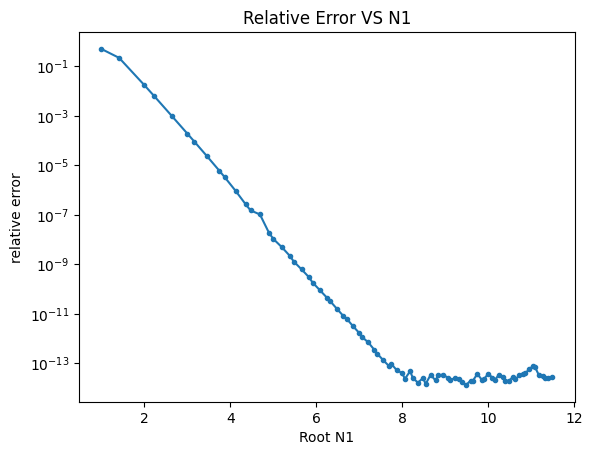

In [ ]:
t1 = (1-np.logspace(-16,0,200)).reshape(200,1)
t = t1[:-1] #removing the zero at the end

#setting inputs
res = -16
n=6

rel_err = rec_err(N1,N2,t,res,n,f)

fig,ax = plt.subplots(1)
ax.plot(np.sqrt(N1),rel_err,".-")

ax.set_yscale('log')
ax.set(xlabel='Root N1',ylabel='relative error',
       title='Relative Error VS N1')

__Adjusting the recurrence relation for matrices__

In [ ]:
def clenshaw_matvec(c, A, u):
    # Clenshaw scheme for evaluating sum c_k T_k(A)*u 
    #where T_k are the Chebyshev
    # polynomials over [-1,1].
    bk1 = np.zeros_like(u)
    bk2 = bk1.copy()
    A = 2 * A
    for k in range(len(c) - 1, 0, -1):
        bk = c[k] * u + A @ bk1 - bk2
        bk2 = bk1.copy()
        bk1 = bk
    y = c[0] * u + 0.5 * (A @ bk1) - bk2
    return y

In [ ]:
def mat_rec_cheb(A,u,n,N1,N2,res):

    fs = np.zeros((n,A.shape[0],1))
    
    ##first term
    a,b,p = coeffs(N1,N2,res)
    I = np.eye(A.shape[0])
    
    f0b = matrix_rat(a,b,p,I-A,u)
    fs[0] = matrix_rat(a,b,p,A,f0b)

    ##second term
    A2 = 2*A-I
    f1coef = chebycoeffs2(f2,1*(max(N1,20)),0)
    
    f1c = clenshaw_matvec(f1coef,A2,f0b)
    fs[1] = f1c 

    ##remaining terms
    for i in range(2,n):
        cheb_cs = chebycoeffs2(f,1*(max(N1,20)),i)
        
        fi = clenshaw_matvec(cheb_cs,A2,fs[i-1])
        fs[i] = fi    
    
    return fs


def mat_rec_true(A,u,n):
    fs = np.zeros((n,A.shape[0],1))

    #first term
    I = np.eye(A.shape[0])
    f0b = scipy.linalg.sqrtm(I-A) @ u
    fs[0] = scipy.linalg.sqrtm(A) @ f0b
    
    #second term
    f1b = scipy.linalg.sqrtm(I+A) @ f0b
    fs[1] = A @ f1b

    #remaining terms
    for i in range(2,n):
        fia = np.linalg.matrix_power(A,2**(i-2))
        fib1 = fia @ fia
        
        fib = scipy.linalg.sqrtm(I+fib1)

        fs[i] = fia @ (fib @ fs[i-1])
        
    return fs

__Testing the Algorithm__

In [ ]:
#forming the matrix
n = 100
k=10
u = np.random.randn(n,1)

A = randmat(n,k)
D = A@np.ones(n)
D = scipy.sparse.diags((1/np.sqrt(D)))

L_norm = identity(n,format='csr') - D@A@D
T = 0.5*L_norm

In [ ]:
#test to find errors
n=10

test = mat_rec_cheb(T.toarray(),u,n,N1[36],N2[36],-32)
test
testTRUE = mat_rec_true(T.toarray(),u,n)
testTRUE

errors = np.zeros(n)
for i in range(n):
    errors[i] = (np.linalg.norm(test[i] - testTRUE[i],
                                ord=np.inf)
                 /np.linalg.norm(testTRUE[i], ord=np.inf))

table1 = errors.reshape((n,1))
numbers = np.linspace(1,n,n)
table = np.column_stack((numbers, table1))

print(tabulate(table, headers=['Recurrence Number','Relative Error'],
               tablefmt='fancy_grid'))

╒═════════════════════╤══════════════════╕
│   Recurrence Number │   Relative Error │
╞═════════════════════╪══════════════════╡
│                   1 │      5.36343e-10 │
├─────────────────────┼──────────────────┤
│                   2 │      6.95443e-15 │
├─────────────────────┼──────────────────┤
│                   3 │      7.84906e-15 │
├─────────────────────┼──────────────────┤
│                   4 │      7.97309e-15 │
├─────────────────────┼──────────────────┤
│                   5 │      9.75619e-15 │
├─────────────────────┼──────────────────┤
│                   6 │      9.77375e-15 │
├─────────────────────┼──────────────────┤
│                   7 │      2.98332e-11 │
├─────────────────────┼──────────────────┤
│                   8 │      2.32605e-05 │
├─────────────────────┼──────────────────┤
│                   9 │    227.278       │
├─────────────────────┼──────────────────┤
│                  10 │      1.43698e+18 │
╘═════════════════════╧══════════════════╛


/var/folders/9l/7llcw8rd1jjgq13k9ckd1sf80000gr/T/ipykernel_12248/1415741659.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  fs[0] = scipy.linalg.sqrtm(A) @ f0b
